In [23]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

train_dir = "..\isec-ic\\dataset\\train"
validation_dir = "..\isec-ic\\dataset\\valid"
test_dir = "..\isec-ic\\dataset\\test"

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))
train_dir = os.path.join(current_dir, train_dir)
validation_dir = os.path.join(current_dir, validation_dir)
test_dir = os.path.join(current_dir, test_dir)

categories = ["bacterialspot", "healthy","lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot" ]

def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder)
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64))
                img = np.array(img) / 255.0
                images.append(img)
                labels.append(categories.index(category))
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")
    return np.array(images), np.array(labels)


x_train, y_train = load_images_from_folder(train_dir)
x_validation, y_validation = load_images_from_folder(validation_dir)
x_test, y_test = load_images_from_folderw(test_dir)

print("Images loaded successfully")

Loading images from category: spidermite and subfolder: Tomato__spidermite
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categories.
Loading images from category: healthy and subfolder: Tomato___healthy
Loading images from category: lateblight and subfolder: Tomato___Lateblight
Loading images from category: leafmold and subfolder: Tomato___Leafmold
Loading images from category: septorialeafspot and subfolder: Tomato___Septorialeafspot
Category: targetspot from subfolder Tomato___Targetspot is not in the list of categories.
Loading images from category: mosaicvirus and subfolder: Tomato___Tomato_mosaicvirus
Loading images from category: yellowleafcurlvirus and subfolder: Tomato___Tomato_yellowleafcurlvirus
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categor

In [30]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

def create_cnn_model(dropout_rate, learning_rate):
    # Garantir que o dropout_rate esteja no intervalo [0, 1)
    #base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    #base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(64, 64, 3)))
    base_model = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(64, 64, 3)))

    for layer in base_model.layers:
        layer.trainable = False

    # Add the dense layers (top layers)
    x = base_model.output
    x = Flatten()(x)  # Flatten the output layer to 1 dimension
    x = Dense(512, activation='relu')(x)   #  First dense layer
    x = Dropout(dropout_rate)(x)  # Dropout to reduce overfitting
    predictions = Dense(len(categories), activation='softmax')(x)  # Output layer

    # Final model
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("Create_cnn_model function loaded")

Create_cnn_model function loaded


In [17]:
from swarm.pso import pso
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

def evaluate_model_PSO(solution):
    dropout_rate, learning_rate = solution
    dropout_rate = abs(dropout_rate)
    learning_rate = abs(learning_rate)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
    auc_scores = []

    for train, val in kfold.split(x_train, y_train):
        model = create_cnn_model(dropout_rate, learning_rate)
        
        # Treina o modelo com os dados de treino e valida nos dados de validação
        model.fit(x_train[train], y_train[train], epochs=5, batch_size=32, verbose=0)
        y_pred = model.predict(x_train[val])
        y_val_categorical = to_categorical(y_train[val], num_classes=len(categories))
        auc_score = roc_auc_score(y_val_categorical, y_pred, multi_class='ovr')
        auc_scores.append(auc_score)
        print(f"   -- generating model with -> dropout_rate: {dropout_rate}, learning_rate: {learning_rate}, auc score: {auc_score}")

    auc_median_score = 1 - np.mean(auc_scores)   # Minimizar 1 - AUC
    print(f" - generated cnn models -> dropout_rate: {dropout_rate}, learning_rate: {learning_rate}, auc median score (minimized): {auc_median_score}")
    
    # Retorna a média do AUC score
    return auc_median_score

# Inicializar e executar PSO
print("Iniciando a otimização com PSO...")
dimension = 2    # Número de dimensões (neste caso, dropout_rate e learning_rate)
lb = [0.1, 0.0001]   # Limites inferiores para dropout_rate e learning_rate
ub = [1, 0.01]    # Limites superiores para dropout_rate e learning_rate

num_agents = 2  # Número de agentes
max_iter = 5    # Número de iterações

# Criando a instância do PSO
pso_instance = pso(n=num_agents, function=evaluate_model_PSO, lb=lb, ub=ub, dimension=dimension, iteration=max_iter)
best_solution = pso_instance.get_Gbest()

best_dropout_rate, best_learning_rate = best_solution
best_dropout_rate = abs(best_dropout_rate)
best_learning_rate = abs(best_learning_rate)
print(f"Melhores parâmetros encontrados: \nBest dropout rate: {best_dropout_rate}, Best Learning Rate: {best_learning_rate}")

Iniciando a otimização com PSO...
 - generated cnn model -> dropout_rate: 0.868274245194535, learning_rate: 0.007649368090811468, auc score: 0.42745243021523094
 - generated cnn model -> dropout_rate: 0.8121780405843094, learning_rate: 0.006027407295593744, auc score: 0.09195122659755417
 - generated cnn model -> dropout_rate: 0.8559206894647304, learning_rate: 0.006002485209077664, auc score: 0.20211072182565648
 - generated cnn model -> dropout_rate: 0.8121780405843094, learning_rate: 0.006027407295593744, auc score: 0.09813893976793653
 - generated cnn model -> dropout_rate: 0.8121780405843094, learning_rate: 0.006027407295593744, auc score: 0.09683431611526205
 - generated cnn model -> dropout_rate: 0.8121780405843094, learning_rate: 0.006027407295593744, auc score: 0.09233177888804411
 - generated cnn model -> dropout_rate: 0.7788575187650155, learning_rate: 0.005204296364559099, auc score: 0.04708568386888312
 - generated cnn model -> dropout_rate: 0.8121780405843094, learning_ra

Treinando o modelo com os melhores hiperparâmetros...
83689472/83683744 [==============================] - 7s 0us/step
Epoch 1/20
375/375 [==============================] - 6s 12ms/step - loss: 2.0456 - accuracy: 0.4252 - val_loss: 0.9456 - val_accuracy: 0.6909
Epoch 2/20
375/375 [==============================] - 4s 10ms/step - loss: 1.2218 - accuracy: 0.5900 - val_loss: 0.7909 - val_accuracy: 0.7403
Epoch 3/20
375/375 [==============================] - 4s 10ms/step - loss: 1.0939 - accuracy: 0.6365 - val_loss: 0.7645 - val_accuracy: 0.7437
Epoch 4/20
375/375 [==============================] - 4s 10ms/step - loss: 1.0506 - accuracy: 0.6464 - val_loss: 0.7153 - val_accuracy: 0.7669
Epoch 5/20
375/375 [==============================] - 4s 10ms/step - loss: 1.0204 - accuracy: 0.6502 - val_loss: 0.6883 - val_accuracy: 0.7722
Epoch 6/20
375/375 [==============================] - 4s 10ms/step - loss: 0.9588 - accuracy: 0.6764 - val_loss: 0.6825 - val_accuracy: 0.7781
Epoch 7/20
375/375 [===

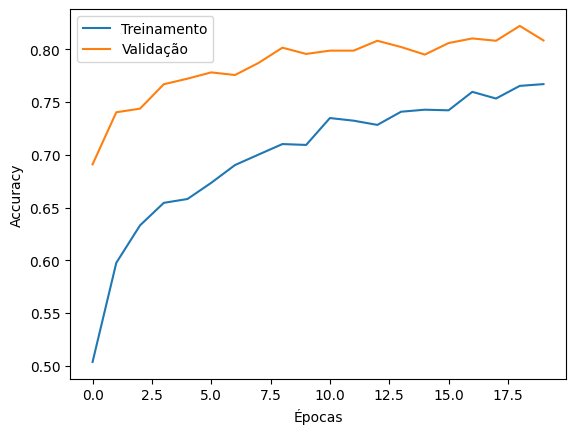

In [31]:
best_learning_rate = 0.003889651856290339 
best_dropout_rate = 0.7057278672251002

print("Treinando o modelo com os melhores hiperparâmetros...")
best_model = create_cnn_model(best_dropout_rate, best_learning_rate)
best_model_history = best_model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(x_validation, y_validation))

best_pso_train_accuracy = best_model_history.history['accuracy'][-1]
best_pso_validation_accuracy = best_model_history.history['val_accuracy'][-1]

print("Melhor Accuracy de Treinamento (CNN VGG-16):", best_pso_train_accuracy)
print("Melhor Accuracy de Validação (CNN VGG-16):", best_pso_validation_accuracy)

import matplotlib.pyplot as plt

# Plotar as curvas de treino e validação
plt.plot(best_model_history.history['accuracy'], label='Treinamento')
plt.plot(best_model_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [32]:
print("Avaliando o modelo no conjunto de teste...")
loss_test, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)

print(f"Acurácia no Teste: {test_accuracy}, Loss: {loss_test}")

Avaliando o modelo no conjunto de teste...
Acurácia no Teste: 0.8100000023841858, Loss: 0.5628936290740967
